In [1]:
library(flexdashboard)
library(immunarch)
library(LymphoSeq)
library(ggplot2)
library(ggfortify)
library(ggpubr)
library(dplyr)
library(data.table)
library(limma)
library(edgeR)
library(som)
library(reshape)
library(reshape2)
library(pheatmap)
library(circlize)
library(ComplexHeatmap)
library(WGCNA)
library(flashClust)
library(LPCM)
library(xfun)

Loading required package: ggplot2

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: dtplyr

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: patchwork

Loading required package: LymphoSeqDB

Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 


Attaching package: ‘reshape’


The following object is masked from ‘package:data.table’:

    melt


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


The following objects are masked from ‘package:data.table’:

    dcast, melt


circlize versi

In [2]:
sc.dir <- "/opt/localdata/sarthak/projects/TCR/tcrquant/trial/"
fl.dir <- "/opt/localdata/sarthak/projects/TCR/data"
er.file <- "/home/cchance/tcr_pipelinelog.txt"
er.msg <- "Early Exit code. Please check error log."
cwd <- "/MBH_Fastq"
fil <- "Yes"
fl <- data.frame(path = list.files(paste(fl.dir,cwd,sep = ""),pattern = ".txt", full.names = T))
fl$id = gsub('/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-','',fl$path)
fl$id = sapply(strsplit(fl$id, split = '_'),'[',1)
fl$no = sapply(strsplit(fl$id, split = '-'),'[',2)
fl$id = sapply(strsplit(fl$id, split = '-'),'[',1)
info = data.frame('id'=c('G2M1A', 'G2M2A', 'G2M3A', 'G3M1A', 'G3M2A', 'G3M3A', 'CM1B', 'CM2B', 'CM3B', 'G2M1B', 'G2M2B', 'G2M3B', 'G3M1B', 'G3M2B','G2M1C', 'G2M2C', 'G2M3C', 'G3M1C', 'G3M2C'))
info$meta =c(rep("A", 6), rep("ctrl", 3), rep("B", 5), rep("C", 5))
fl = merge(fl,info, by = 'id')
fl[is.na(fl$no),]$no = 1
files.A <- subset(fl, no < 2 & meta == 'A')$path
files.B <- subset(fl, no < 2 & meta == 'B')$path
files.C <- subset(fl, no < 2 & meta == 'C')$path

In [ ]:
fl

In [3]:
immdataA <- repLoad(paste(files.A,sep = ""), .format = 'mixcr')
immdataB <- repLoad(paste(files.B,sep = ""), .format = 'mixcr')
immdataC <- repLoad(paste(files.C,sep = ""), .format = 'mixcr')
save(immdataA, file = paste(fl.dir,cwd,'/immdataA.rda',sep = ""))
save(immdataB, file = paste(fl.dir,cwd,'/immdataB.rda',sep = ""))
save(immdataC, file = paste(fl.dir,cwd,'/immdataC.rda',sep = ""))
load(paste(fl.dir,cwd,'/immdataA.rda',sep = "" ))
load(paste(fl.dir,cwd,'/immdataB.rda',sep = "" ))
load(paste(fl.dir,cwd,'/immdataC.rda',sep = "" ))

Warning message in repLoad(paste(files.A, sep = ""), .format = "mixcr"):
“Please don't provide the .format argument,
            immunarch detects the format automatically.
            The .format argument will soon be removed.”

== Step 1/3: loading repertoire files... ==


Processing "<initial>" ...

  -- [1/6] Parsing "/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-G2M1A_S14_L001_R.txt" -- 
mixcr

  -- [2/6] Parsing "/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-G2M2A_S15_L001_R.txt" -- 
mixcr

  -- [3/6] Parsing "/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-G2M3A_S16_L001_R.txt" -- 
mixcr

  -- [4/6] Parsing "/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-G3M1A_S17_L001_R.txt" -- 
mixcr

  -- [5/6] Parsing "/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-G3M2A_S18_L001_R.txt" -- 
mixcr

  -- [6/6] Parsing "/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/MBH-69933-G3M3A_S19_L001_R.txt" -- 
mixcr


== Step 2/3

In [4]:
load(paste(fl.dir,cwd,'/immdataA.rda',sep = "" ))
load(paste(fl.dir,cwd,'/immdataB.rda',sep = "" ))
load(paste(fl.dir,cwd,'/immdataC.rda',sep = "" ))

In [5]:
dir.create(paste(fl.dir,cwd,"/A",sep = ""),mode = "0777")
dir.create(paste(fl.dir,cwd,"/B",sep = ""),mode = "0777")
dir.create(paste(fl.dir,cwd,"/C",sep = ""),mode = "0777")

 for (sam in 1:length(immdataA$data))
 {
   sample_name <- names(immdataA$data)[sam]
   samp <- immdataA$data[[sam]]
   samp <- samp[,c("CDR3.aa","CDR3.nt","Clones","Proportion","V.name","J.name","D.name")]
   colnames(samp) <- c("aminoAcid","nucleotide","count","frequencyCount","vGeneName","jGeneName","dGeneName")
   samp$cdr3Length <- nchar(samp$nucleotide)
   samp$vFamilyName <- strsplit2(samp$vGeneName, split = "-")[,1]
   samp$jFamilyName <- strsplit2(samp$jGeneName, split = "-")[,1]
   samp$dFamilyName <- strsplit2(samp$dGeneName, split = "-")[,1]
   write.table(samp, file = paste(fl.dir,cwd,"/A/",sample_name,".tsv",sep = ''),sep = "\t", quote = FALSE, row.names = FALSE)
 }
 for (sam in 1:length(immdataB$data))
 {
   sample_name <- names(immdataB$data)[sam]
   samp <- immdataA$data[[sam]]
   samp <- samp[,c("CDR3.aa","CDR3.nt","Clones","Proportion","V.name","J.name","D.name")]
   colnames(samp) <- c("aminoAcid","nucleotide","count","frequencyCount","vGeneName","jGeneName","dGeneName")
   samp$cdr3Length <- nchar(samp$nucleotide)
   samp$vFamilyName <- strsplit2(samp$vGeneName, split = "-")[,1]
   samp$jFamilyName <- strsplit2(samp$jGeneName, split = "-")[,1]
   samp$dFamilyName <- strsplit2(samp$dGeneName, split = "-")[,1]
   write.table(samp, file = paste(fl.dir,cwd,"/B/",sample_name,".tsv",sep = ''),sep = "\t", quote = FALSE, row.names = FALSE)
 }
 for (sam in 1:length(immdataC$data))
 {
   sample_name <- names(immdataC$data)[sam]
   samp <- immdataC$data[[sam]]
   samp <- samp[,c("CDR3.aa","CDR3.nt","Clones","Proportion","V.name","J.name","D.name")]
   colnames(samp) <- c("aminoAcid","nucleotide","count","frequencyCount","vGeneName","jGeneName","dGeneName")
   samp$cdr3Length <- nchar(samp$nucleotide)
   samp$vFamilyName <- strsplit2(samp$vGeneName, split = "-")[,1]
   samp$jFamilyName <- strsplit2(samp$jGeneName, split = "-")[,1]
   samp$dFamilyName <- strsplit2(samp$dGeneName, split = "-")[,1]
   write.table(samp, file = paste(fl.dir,cwd,"/C/",sample_name,".tsv",sep = ''),sep = "\t", quote = FALSE, row.names = FALSE)
 }

Warning message in dir.create(paste(fl.dir, cwd, "/A", sep = ""), mode = "0777"):
“'/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/A' already exists”
Warning message in dir.create(paste(fl.dir, cwd, "/B", sep = ""), mode = "0777"):
“'/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/B' already exists”
Warning message in dir.create(paste(fl.dir, cwd, "/C", sep = ""), mode = "0777"):
“'/opt/localdata/sarthak/projects/TCR/data/MBH_Fastq/C' already exists”


In [ ]:
 for (sam in 1:length(immdataA))
 {
   sample_name <- names(immdataA)[sam]
   samp <- immdataA[[sam]]
   samp <- samp[,c("CDR3.amino.acid.sequence","CDR3.nucleotide.sequence","Read.count","Read.proportion","V.gene","J.gene","D.gene")]
   colnames(samp) <- c("aminoAcid","nucleotide","count","frequencyCount","vGeneName","jGeneName","dGeneName")
   samp$cdr3Length <- nchar(samp$nucleotide)
   samp$vFamilyName <- strsplit2(samp$vGeneName, split = "-")[,1]
   samp$jFamilyName <- strsplit2(samp$jGeneName, split = "-")[,1]
   samp$dFamilyName <- strsplit2(samp$dGeneName, split = "-")[,1]
   write.table(samp, file = paste(fl.dir,cwd,"/A/",sample_name,".tsv",sep = ''),sep = "\t", quote = FALSE, row.names = FALSE)
 }


In [6]:
immdata <- c(immdataA$data,immdataB$data,immdataC$data)
TCRB.list.A <- readImmunoSeq(path = paste(fl.dir,cwd,"/A",sep = ""))
TCRB.list.B <- readImmunoSeq(path = paste(fl.dir,cwd,"/B",sep = ""))
TCRB.list.C <- readImmunoSeq(path = paste(fl.dir,cwd,"/C",sep = ""))
TCRB.list <- c(TCRB.list.A, TCRB.list.B, TCRB.list.C)
numA <- length(TCRB.list.A)
numB <- length(TCRB.list.B)
numC <- length(TCRB.list.C)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [7]:
numA
numB
numC

[1] 6

[1] 5

[1] 5

In [8]:
productive.TRB.aa <- productiveSeq(file.list = TCRB.list, aggregate = "aminoAcid", 
                               prevalence = FALSE)
productive.TRB.nt <- productiveSeq(file.list = TCRB.list, aggregate = "nucleotide", 
                               prevalence = FALSE)

  |======================================================================| 100%
  |======================================================================| 100%


In [ ]:
productive.TRB.nt

In [9]:
logcpm <- function(CountMatrix, method = "quantile")
{
  # DGE Object
  dge <- DGEList(CountMatrix)
  # Normalization by voom
  dge_voom <- voom(dge, plot = FALSE, normalize.method = method)
  dge_norm <- data.frame(dge_voom$E)
  return(dge_norm)
}

In [ ]:
# Alpha-Beta Pairwise correlation
# Alpha chain Sequences
tra1 <- productive.TRB.nt[[1]]
tra1 <- data.frame(aminoAcid = tra1[grep("TRA_*",tra1$vFamilyName),1])
for (file in names(productive.TRB.nt))
{
  tra <- productive.TRB.nt[[file]]
  tra <- tra[grep("TRA_*",tra$vFamilyName),c(1,3)]
  tra <- aggregate(count ~ aminoAcid, data = tra, FUN = sum)
  colnames(tra) <- c("aminoAcid",file)
  tra1 <- merge(tra1,tra, by = "aminoAcid", all = T)
}
tra1 <- tra1[complete.cases(tra1),]
tra1 <- tra1[!(duplicated(tra1)),]
#tra1[t(apply(tra1, 1, is.na))] = 0
row.names(tra1) <- tra1$aminoAcid
tra1$aminoAcid = NULL
#tra1 <- tra1 + 1
tra_norm <- logcpm(tra1)
T_tra_norm <- t(tra_norm)

In [10]:
cl <- clonality(file.list = TCRB.list)
productive.raw.count <- productive.TRB.aa
unique.seqs <- uniqueSeqs(productive.aa = productive.TRB.aa)

In [ ]:
df2

No id variables; using all as measure variables



[1] "filtered to common cdr3 sequences only"


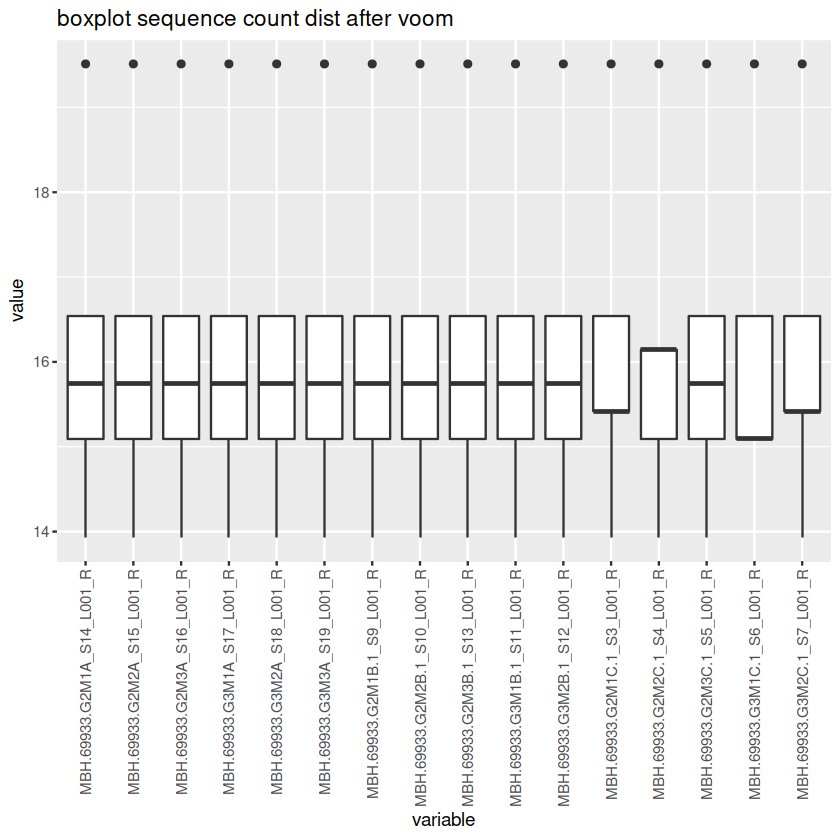

In [11]:
# Voom Normalize count data
source(paste(sc.dir,"/quantile.R",sep = ""))
print(note)
if (dim(df3)[1] != 0)
{
  gseqplot <- ggplot(dge_melt, aes(x = variable, y = value)) + geom_boxplot(stat = "boxplot") + ggtitle("boxplot sequence count dist after voom") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
  print(gseqplot)
}

In [ ]:
write.table(dge_norm, paste(fl.dir,cwd,"/dge_norm.csv",sep=""), sep=",", quote=FALSE)

No id variables; using all as measure variables



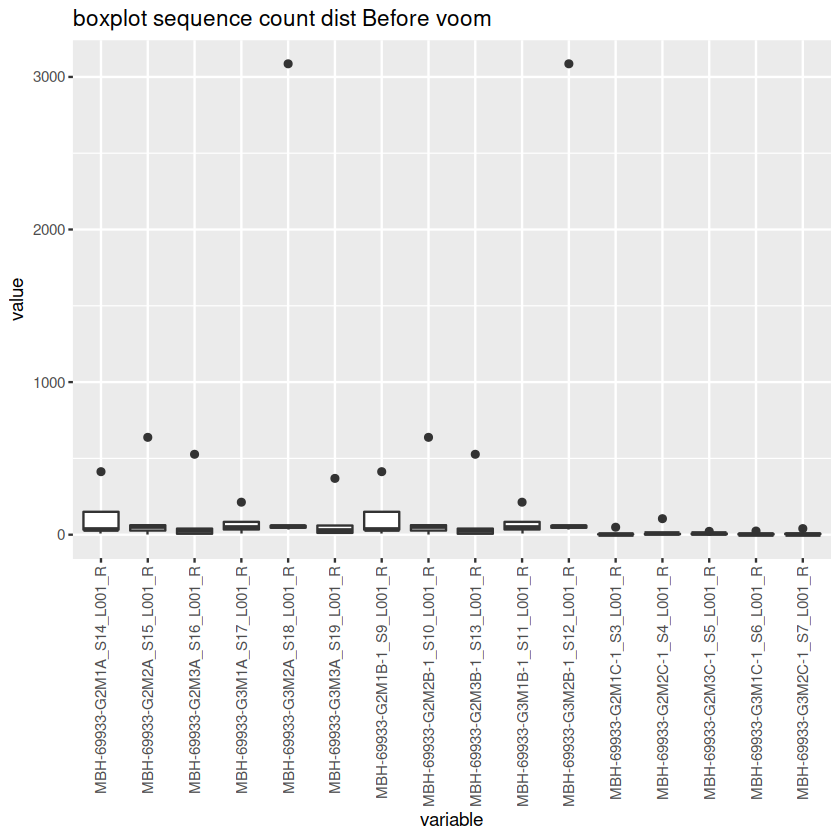

In [12]:
if (dim(df3)[1] != 0)
{
  df3_melt <- melt(df3)
  gseq <- ggplot(df3_melt, aes(x = variable, y = value)) + geom_boxplot(stat = "boxplot") + ggtitle("boxplot sequence count dist Before voom") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
  print(gseq)
}

In [ ]:
print(cl[,c(1:2,4:5)])
#embed_file(paste(fl.dir,cwd,"/dge_norm.csv",sep=""), text='Download normalized counts')

In [13]:
#print(cl[,c(1:2,4:5)])
foo = cl
foo$meta = NA
foo$meta[grepl('A_', foo$sample)] = 'A'
foo$meta[grepl('A-', foo$sample)] = 'A'
foo$meta[grepl('B_', foo$sample)] = 'B'
foo$meta[grepl('B-', foo$sample)] = 'B'
foo$meta[grepl('C_', foo$sample)] = 'C'
foo$meta[grepl('C-', foo$sample)] = 'C'

In [14]:
print(foo[order(foo$meta),c(1:2,4:5,9)])

                        samples totalSequences totalCount clonality meta
1    MBH-69933-G3M2A_S18_L001_R           9316      91148  0.079286    A
6    MBH-69933-G2M3A_S16_L001_R           8149      82437  0.065932    A
8    MBH-69933-G2M2A_S15_L001_R           6678      72406  0.068286    A
11   MBH-69933-G3M1A_S17_L001_R           9429      79499  0.068836    A
13   MBH-69933-G3M3A_S19_L001_R          12665      96979  0.067949    A
14   MBH-69933-G2M1A_S14_L001_R           7723     145280  0.070625    A
2  MBH-69933-G3M2B-1_S12_L001_R           9316      91148  0.079286    B
7  MBH-69933-G2M3B-1_S13_L001_R           8149      82437  0.065932    B
9  MBH-69933-G2M2B-1_S10_L001_R           6678      72406  0.068286    B
12 MBH-69933-G3M1B-1_S11_L001_R           9429      79499  0.068836    B
15  MBH-69933-G2M1B-1_S9_L001_R           7723     145280  0.070625    B
3   MBH-69933-G3M2C-1_S7_L001_R           7632      11658  0.021243    C
4   MBH-69933-G2M1C-1_S3_L001_R           3057     

In [ ]:
clmn <- 'Read.count'
vis(repDiversity(immdata, "raref"))

In [ ]:
vis(repDiversity(immdataA$data, "raref"))

In [ ]:
vis(repDiversity(immdataB$data, "raref"))

In [ ]:
vis(repDiversity(immdataC$data, "raref"))

In [ ]:
immdata <- c(immdataA$data,immdataB$data,immdataC$data)
new_name = vector(length= length(names(immdata)))
print(names(immdata))
new_name[grepl('A_', names(immdata))] = 'A'
new_name[grepl('A-', names(immdata))] = 'A'
new_name[grepl('B_', names(immdata))] = 'B'
new_name[grepl('B-', names(immdata))] = 'B'
new_name[grepl('C_', names(immdata))] = 'C'
new_name[grepl('C-', names(immdata))] = 'C'
groups = new_name
new_name = paste(new_name,c(seq(1,numA),seq(1,numB),seq(1,numC)))
names(immdata) = new_name
print(names(immdata))
meta <- data.frame(new_name,groups)
names(meta) <- c('Sample','groups')

In [ ]:
vis(repDiversity(immdata, "raref"),.by = 'groups',.meta = meta)

In [ ]:
immdata <- c(immdataA$data,immdataB$data,immdataC$data)
div <- repDiversity(immdata, 'div', .do.norm = T)
div.df <- data.frame(div = div)
div.df$group <- c(rep("A",numA), rep("B",numB),rep("C",numC))
#div.df$group <- c(rep("Control",2), rep("Vaccine",2),rep("Vaccine+PDL1",2))
gdiv <- ggplot(data = div.df, aes(y = div.Value, x = div.Sample, fill = group)) + geom_bar(stat = "identity") + xlab("Samples") + ylab("Diversity") + ggtitle("True Diversity Index") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), panel.background = element_blank(), axis.line = element_line())
print(gdiv)

In [ ]:
div <- repDiversity(immdata, 'inv.simp', .do.norm = T)
div.df <- data.frame(div = div)
div.df$group <- c(rep("A",numA), rep("B",numB),rep("C",numC))
#div.df$group <- c(rep("Control",2), rep("Vaccine",2),rep("Vaccine+PDL1",2))
gsimp <- ggplot(data = div.df, aes(y = div.Value, x = div.Sample, fill = group)) + geom_bar(stat = "identity") + xlab("Samples") + ylab("Diversity") + ggtitle("Inverse Simpson Index") + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), panel.background = element_blank(), axis.line = element_line())
print(gsimp)

In [ ]:
similarity.matrix <- bhattacharyyaMatrix(productive.seqs = productive.TRB.aa)
pc <- prcomp(similarity.matrix)
pc.df <- as.data.frame(pc$x)
pc.df$sample <- row.names(pc.df)
foo = pc.df
foo$meta = NA
foo$meta[grepl('A_', foo$sample)] = 'A'
foo$meta[grepl('A-', foo$sample)] = 'A'
foo$meta[grepl('B_', foo$sample)] = 'B'
foo$meta[grepl('B-', foo$sample)] = 'B'
foo$meta[grepl('C_', foo$sample)] = 'C'
foo$meta[grepl('C-', foo$sample)] = 'C'
pc.df = foo
autoplot(pc, data = pc.df, colour = 'meta', size = 3.0, xlim = c(-0.125,0),ylim = c(-0.08,0.04))

In [ ]:
pc.df

In [ ]:
try(hc <- hclust(dist(similarity.matrix)), silent = T)
try(plot(hc, xlab = "Samples", hang = -1), silent = T)

Using frequencyCount as value column.  Use the value argument to cast to override this choice

Using aminoAcid, type as id variables



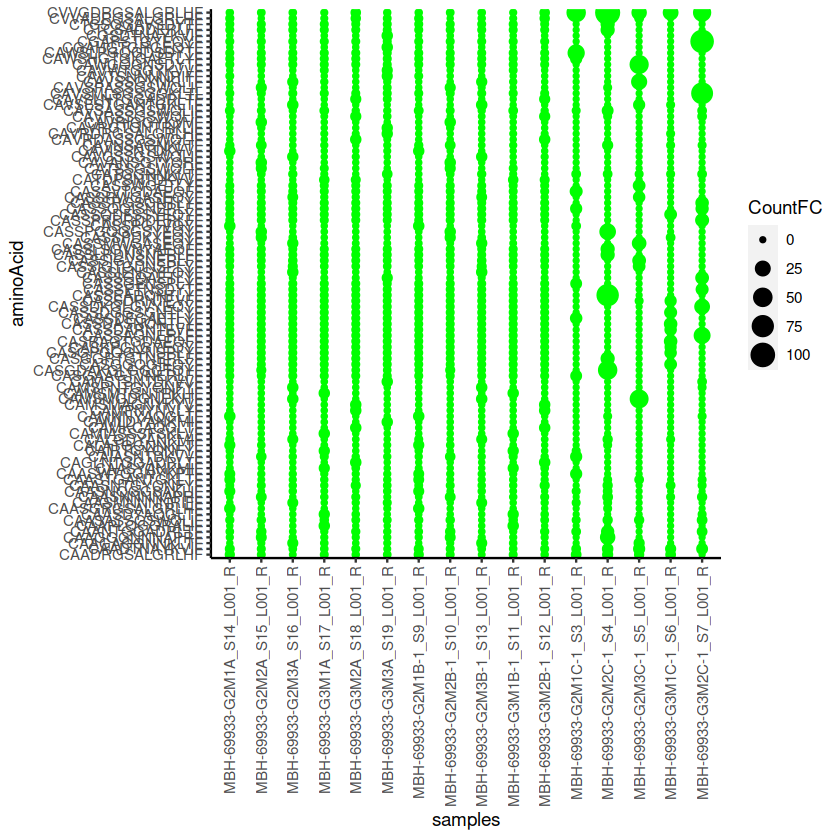

In [15]:
top.seqs <- topSeqs(productive.seqs = productive.TRB.aa, top = 10)
top.seqs$count = NULL
top_cast <- cast(top.seqs, aminoAcid ~ samples)
seqs2 <- data.frame(aminoAcid = top_cast$aminoAcid)
for (i in names(productive.TRB.aa))
{
  aa <- top_cast$aminoAcid
  x <- productive.TRB.aa[[i]]
  seqs <- x[x$aminoAcid %in% aa,c(1,2)]
  colnames(seqs) <- c("aminoAcid",i)
  seqs2 <- merge(seqs2, seqs, by = "aminoAcid", all = T)
}
seqs2[t(apply(seqs2, 1, is.na))] = 0
seqs2[,2:(numA+numC+1)] <- seqs2[,2:(numA+numC+1)] + 1
write.table(seqs2, paste(fl.dir,cwd,"/topseqs_unscaled.csv",sep=""), sep=",", quote=FALSE)
if (numA > 1)
{
  seqs2$scale <- apply(seqs2[,2:(numA+1)],1,mean)
} else {
    seqs2$scale <- seqs2[,2]
}
seqs2[,2:(numA+numC+1)] <- seqs2[,2:(numA+numC+1)] / seqs2$scale
seqs2$scale = NULL
write.table(seqs2, paste(fl.dir,cwd,"/topseqs_scaled.csv",sep=""), sep=",", quote=FALSE)
seqs2$sig <- apply(seqs2[,(numA+2):(numA+numC+1)],1,mean)
seqs2$type <- "2"
seqs2$type[seqs2$sig >= 2.0] = "3"
seqs2$type[seqs2$sig < 2.0] = "1"
seqs2$sig = NULL
seqs2_melt <- melt(seqs2, variable_name = "type")
colnames(seqs2_melt) <- c("aminoAcid", "type", "samples", "CountFC")
fl2 <- colorRamp2(c(1,2,3), colors = c("green","grey76","red"))
g <- ggplot(seqs2_melt, aes(x = samples, y = aminoAcid, size = CountFC)) + geom_point(color = fl2(as.numeric(as.character(seqs2_melt$type)))) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), panel.background = element_blank(), axis.line = element_line())
print(g)

In [ ]:
top.seqs <- topSeqs(productive.seqs = productive.TRB.aa, top = 10)
top.seqs$count = NULL
top_cast <- cast(top.seqs, aminoAcid ~ samples)
seqs2 <- data.frame(aminoAcid = top_cast$aminoAcid)
for (i in names(productive.TRB.aa))
{
  aa <- top_cast$aminoAcid
  x <- productive.TRB.aa[[i]]
  seqs <- x[x$aminoAcid %in% aa,c(1,2)]
  colnames(seqs) <- c("aminoAcid",i)
  seqs2 <- merge(seqs2, seqs, by = "aminoAcid", all = T)
}
seqs2[t(apply(seqs2, 1, is.na))] = 0
seqs2[,2:(numA+numC+1)] <- seqs2[,2:(numA+numC+1)] + 1
write.table(seqs2, paste(fl.dir,cwd,"/topseqs_unscaled.csv",sep=""), sep=",", quote=FALSE)
if (numA > 1)
{
  seqs2$scale <- apply(seqs2[,2:(numA+1)],1,mean)
} else {
    seqs2$scale <- seqs2[,2]
}
seqs2[,2:(numA+numC+1)] <- seqs2[,2:(numA+numC+1)] / seqs2$scale
seqs2$scale = NULL

In [ ]:
library(tidyverse)
foo <- seqs2 %>% pivot_longer(!aminoAcid, names_to = 'sample', values_to = 'counts')
foo$meta = NA
foo$meta[grepl('A_', foo$sample)] = 'A'
foo$meta[grepl('A-', foo$sample)] = 'A'
foo$meta[grepl('B_', foo$sample)] = 'B'
foo$meta[grepl('B-', foo$sample)] = 'B'
foo$meta[grepl('C_', foo$sample)] = 'C'
foo$meta[grepl('C-', foo$sample)] = 'C'

In [ ]:
foo %>% filter(aminoAcid == 'CAADRGSALGRLHF')

In [ ]:
seqs2$sig <- apply(seqs2[,(numA+2):(numA+numC+1)],1,mean)
table(seqs2$type)

In [ ]:
quantile(seqs2_melt$CountFC,0.80)
quantile(seqs2_melt$CountFC,0.20)
seqs2_melt1 <- seqs2_melt %>% filter(CountFC > 1)
seqs2_melt2 <- seqs2_melt %>% filter(CountFC < 0.03)
g <- ggplot(seqs2_melt1,aes(x = samples, y = aminoAcid, size = CountFC)) + geom_point(color = fl2(as.numeric(as.character(seqs2_melt1$type)))) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), panel.background = element_blank(), axis.line = element_line())
print(g)
#seqs2_melt %>% filter(CountFC > 1)
g <- ggplot(seqs2_melt2,aes(x = samples, y = aminoAcid, size = CountFC)) + geom_point(color = fl2(as.numeric(as.character(seqs2_melt2$type)))) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), panel.background = element_blank(), axis.line = element_line())
print(g)

In [ ]:
immdata <- c(immdataA$data,immdataB$data,immdataC$data)
new_name = vector(length= length(names(immdata)))
print(names(immdata))
new_name[grepl('A_', names(immdata))] = 'A'
new_name[grepl('A-', names(immdata))] = 'A'
new_name[grepl('B_', names(immdata))] = 'B'
new_name[grepl('B-', names(immdata))] = 'B'
new_name[grepl('C_', names(immdata))] = 'C'
new_name[grepl('C-', names(immdata))] = 'C'
groups = new_name
new_name = paste(new_name,c(seq(1,numA),seq(1,numB),seq(1,numC)))
names(immdata) = new_name
print(names(immdata))
imm_pr <- repClonality(immdata, .method = "clonal.prop")
vis(imm_pr)

In [ ]:
meta <- data.frame(new_name,groups)
names(meta) <- c('Sample','groups')
#vis(div_chao, .by = 'groups',.meta = groups)
vis(imm_pr, .by = 'groups',.meta = meta)

In [ ]:
imm_top <- repClonality(immdata, .method = "top", .head = c(10, 100, 1000, 3000, 10000))
vis(imm_top)

In [ ]:
vis(imm_top, .by = 'groups',.meta = meta)

In [ ]:
imm_rare <- repClonality(immdata, .method = "rare")
vis(imm_rare)

In [ ]:
imm_hom <- repClonality(immdata, .method = "homeo")
vis(imm_hom)

In [ ]:
immdata <- c(immdataA$data,immdataC$data)
new_name = vector(length= length(names(immdata)))
print(names(immdata))
new_name[grepl('A_', names(immdata))] = 'A'
#new_name[grepl('A-', names(immdata)] = 'A'
new_name[grepl('C_', names(immdata))] = 'C'
new_name[grepl('C-', names(immdata))] = 'C'
groups = new_name
new_name = paste(new_name,c(seq(1,numA),seq(1,numC)))
names(immdata) = new_name
print(names(immdata))

In [ ]:
meta <- data.frame(new_name,groups)
names(meta) <- c('Sample','groups')
#vis(div_chao, .by = 'groups',.meta = groups)

In [ ]:
# Compute statistics and visualise them
# Chao1 diversity measure
div_chao <- repDiversity(immdata, "chao1")

# Hill numbers
div_hill <- repDiversity(immdata, "hill")

# D50
div_d50 <- repDiversity(immdata, "d50")

# Ecological diversity measure
div_div <- repDiversity(immdata, "div")

p1 <- vis(div_chao)
p2 <- vis(div_chao, .by = 'groups',.meta = meta)
p3 <- vis(div_hill, .by = 'groups',.meta = meta)

p4 <- vis(div_d50)
p5 <- vis(div_d50, .by = 'groups',.meta = meta)
p6 <- vis(div_div)
p7 <- vis(div_div, .by = 'groups',.meta = meta)


In [ ]:
print(p1)
print(p2)
print(p3)
print(p4)
print(p5)
print(p6)
print(p7)

In [ ]:
vis(imm_top,.by = 'groups',.meta = meta)

In [ ]:
Genes <- geneFreq(productive.nt = productive.TRB.nt, locus = "VDJ", family = TRUE)
# Count Matrix
GeneMat <- reshape::cast(Genes, familyName ~ samples, value = "count", sum)
rownames(GeneMat) = as.character(GeneMat$familyName)
GeneMat$familyName = NULL

# Voom Normalize Count Matrix
dge <- DGEList(GeneMat)
dge_voom <- voom(dge,plot = FALSE, normalize.method = "quantile")
dge_norm <- data.frame(dge_voom$E)
rownames(dge_norm) <- dge_norm$familyName
dge_norm$familyName = NULL
dge_melt <- melt(dge_norm)
ggeneplot <- ggplot(dge_melt, aes(x = variable, y = value)) + geom_boxplot(stat = "boxplot") + ggtitle("boxplot gene count dist after voom") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
dge_norm <- t(apply(dge_norm, 1, rev))

if (min(dge_norm) < 0)
{
  dge_norm <- dge_norm + abs(min(dge_norm))
}

In [ ]:
# p-value based Differential Expression Analysis using edgeR
group <- c(rep("A",numA),rep("B",numB),rep("C",numC))

# DGEList object 
dgList <- DGEList(counts = dge_norm, genes = rownames(dge_norm), group = group)
designMat <- model.matrix(~group)

# Estimate Dispersions
dgList <- estimateGLMCommonDisp(dgList, design=designMat)
dgList <- estimateGLMTrendedDisp(dgList, design=designMat)
dgList <- estimateGLMTagwiseDisp(dgList, design=designMat)

# Differential Expression
fit <- glmFit(dgList, designMat)
lrt <- glmLRT(fit, coef=2)
p = min(lrt$table$PValue)
d = dim(lrt$table)[1]

edgeR_result <- topTags(lrt, n = 50)
d = dim(edgeR_result$table)[1]

seqmat_final <- dge_norm[rownames(dge_norm) %in% edgeR_result$table$genes,]

In [ ]:
dim(seqmat_final)[1]

In [ ]:
  source(paste(sc.dir,"/som_test2.R",sep = ""))
  seq2 <- som::normalize(seqmat_final)
  fl <- colorRamp2(c(min(seq2),0,max(seq2)), colors = c("Green", "Black", "Red"))
  print(Heatmap(seq2,col = fl, cluster_columns = F))


In [ ]:
  sg <- list()
  for (n in 1:num)
  {
    sg[[n]] <- smap(in.som,seqmat_final,n,0.3,"Genes ")
  }
  ggarrange(plotlist=sg, widths = c(1,1))

In [ ]:
print(ggeneplot)

In [ ]:
names(seq2) 

In [ ]:
top.seqs <- topSeqs(productive.seqs = productive.TRB.aa, top = 10)
top.seqs$count = NULL
top_cast <- cast(top.seqs, aminoAcid ~ samples)
seqs2 <- data.frame(aminoAcid = top_cast$aminoAcid)
for (i in names(productive.TRB.aa))
{
  aa <- top_cast$aminoAcid
  x <- productive.TRB.aa[[i]]
  seqs <- x[x$aminoAcid %in% aa,c(1,2)]
  colnames(seqs) <- c("aminoAcid",i)
  seqs2 <- merge(seqs2, seqs, by = "aminoAcid", all = T)
}
seqs2[t(apply(seqs2, 1, is.na))] = 0
seqs2[,2:(numA+numC+1)] <- seqs2[,2:(numA+numC+1)] + 1
#write.table(seqs2, paste(fl.dir,cwd,"/topseqs_unscaled.csv",sep=""), sep=",", quote=FALSE)
if (numA > 1)
{
  seqs2$scale <- apply(seqs2[,2:(numA+1)],1,mean)
} else {
    seqs2$scale <- seqs2[,2]
}
seqs2[,2:(numA+numB+numC+1)] <- seqs2[,2:(numA+numB+numC+1)] / seqs2$scale
seqs2$scale = NULL
#write.table(seqs2, paste(fl.dir,cwd,"/topseqs_scaled.csv",sep=""), sep=",", quote=FALSE)
seqs2$sig <- apply(seqs2[,(numA+numB+2):(numA+numB+numC+1)],1,mean)
print(summary(seqs2$sig))
cut = quantile(seqs2$sig)
seqs2$type <- "2"
seqs2$type[seqs2$sig >= cut] = "3"
seqs2$type[seqs2$sig < cut] = "1"
seqs2$sig = NULL

In [ ]:
)

In [ ]:
top.seqs <- topSeqs(productive.seqs = productive.TRB.aa, top = 10)
top.seqs$count = NULL
top_cast <- cast(top.seqs, aminoAcid ~ samples)
seqs2 <- data.frame(aminoAcid = top_cast$aminoAcid)
for (i in names(productive.TRB.aa))
{
  aa <- top_cast$aminoAcid
  x <- productive.TRB.aa[[i]]
  seqs <- x[x$aminoAcid %in% aa,c(1,2)]
  colnames(seqs) <- c("aminoAcid",i)
  seqs2 <- merge(seqs2, seqs, by = "aminoAcid", all = T)
}
seqs2[t(apply(seqs2, 1, is.na))] = 0
seqs2[,2:(numA+numB+numB+numC+1)] <- seqs2[,2:(numA+numB+numC+1)] + 1
write.table(seqs2, paste(fl.dir,cwd,"/topseqs_unscaled.csv",sep=""), sep=",", quote=FALSE)
if (numA > 1)
{
  seqs2$scale <- apply(seqs2[,2:(numA+1)],1,mean)
} else {
    seqs2$scale <- seqs2[,2]
}
seqs2[,2:(numA+numB+numC+1)] <- seqs2[,2:(numA+numC+1)] / seqs2$scale
seqs2$scale = NULL
#write.table(seqs2, paste(fl.dir,cwd,"/topseqs_scaled.csv",sep=""), sep=",", quote=FALSE)
seqs2$sig <- apply(seqs2[,(numA+2):(numA+numB+numC+1)],1,mean)
seqs2$type <- "2"
seqs2$type[seqs2$sig >= 2.0] = "3"
seqs2$type[seqs2$sig < 2.0] = "1"
seqs2$sig = NULL
seqs2_melt <- melt(seqs2, variable_name = "type")
colnames(seqs2_melt) <- c("aminoAcid", "type", "samples", "CountFC")
fl2 <- colorRamp2(c(1,2,3), colors = c("green","grey76","red"))
g <- ggplot(seqs2_melt, aes(x = samples, y = aminoAcid, size = CountFC)) + geom_point(color = fl2(as.numeric(as.character(seqs2_melt$type)))) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1), panel.background = element_blank(), axis.line = element_line())
print(g)

In [91]:
top.seqs <- topSeqs(productive.seqs = productive.TRB.aa, top = 10)
top.seqs$count = NULL
top_cast <- cast(top.seqs, aminoAcid ~ samples)
seqs2 <- data.frame(aminoAcid = top_cast$aminoAcid)
for (i in names(productive.TRB.aa))
{
  aa <- top_cast$aminoAcid
  x <- productive.TRB.aa[[i]]
  seqs <- x[x$aminoAcid %in% aa,c(1,2)]
  colnames(seqs) <- c("aminoAcid",i)
  seqs2 <- merge(seqs2, seqs, by = "aminoAcid", all = T)
}
seqs2[t(apply(seqs2, 1, is.na))] = 0
seqs2[,2:(numA+numB+numC+1)] <- seqs2[,2:(numA+numB+numC+1)] + 1
write.table(seqs2, paste(fl.dir,cwd,"/topseqs_unscaled.csv",sep=""), sep=",", quote=FALSE)
if (numA > 1)
{
  seqs2$scale <- apply(seqs2[,2:(numA+1)],1,mean)
} else {
    seqs2$scale <- seqs2[,2]
}
seqs2[,2:(numA+numB+numC+1)] <- seqs2[,2:(numA+numB+numC+1)] / seqs2$scale
seqs2$scale = NULL
#write.table(seqs2, paste(fl.dir,cwd,"/topseqs_scaled.csv",sep=""), sep=",", quote=FALSE)
#seqs2$sig <- apply(seqs2[,(numA+2):(numA+numB+numC+1)],1,mean)

Using frequencyCount as value column.  Use the value argument to cast to override this choice



In [92]:
colnames(seqs2)

[1] "aminoAcid"                    "MBH-69933-G2M1A_S14_L001_R"  
 [3] "MBH-69933-G2M2A_S15_L001_R"   "MBH-69933-G2M3A_S16_L001_R"  
 [5] "MBH-69933-G3M1A_S17_L001_R"   "MBH-69933-G3M2A_S18_L001_R"  
 [7] "MBH-69933-G3M3A_S19_L001_R"   "MBH-69933-G2M1B-1_S9_L001_R" 
 [9] "MBH-69933-G2M2B-1_S10_L001_R" "MBH-69933-G2M3B-1_S13_L001_R"
[11] "MBH-69933-G3M1B-1_S11_L001_R" "MBH-69933-G3M2B-1_S12_L001_R"
[13] "MBH-69933-G2M1C-1_S3_L001_R"  "MBH-69933-G2M2C-1_S4_L001_R" 
[15] "MBH-69933-G2M3C-1_S5_L001_R"  "MBH-69933-G3M1C-1_S6_L001_R" 
[17] "MBH-69933-G3M2C-1_S7_L001_R"

In [93]:
#library(tidyverse)
seqs2 = seqs2 %>% pivot_longer(!aminoAcid, names_to ='sample', values_to = 'count')

In [94]:
seqs2$meta = NA
seqs2$meta[grepl('A_', seqs2$sample)] = 'A'
seqs2$meta[grepl('A-', seqs2$sample)] = 'A'
seqs2$meta[grepl('B_', seqs2$sample)] = 'B'
seqs2$meta[grepl('B-', seqs2$sample)] = 'B'
seqs2$meta[grepl('C_', seqs2$sample)] = 'C'
seqs2$meta[grepl('C-', seqs2$sample)] = 'C'

In [95]:
seqs2 = seqs2 %>% group_by(aminoAcid) %>%  mutate(median_by_AA = median(count))

In [96]:
summary(seqs2)

  aminoAcid            sample              count              meta          
 Length:1520        Length:1520        Min.   : 0.00980   Length:1520       
 Class :character   Class :character   1st Qu.: 0.04167   Class :character  
 Mode  :character   Mode  :character   Median : 0.39765   Mode  :character  
                                       Mean   : 1.28616                     
                                       3rd Qu.: 1.00000                     
                                       Max.   :89.00000                     
  median_by_AA    
 Min.   :0.01373  
 1st Qu.:0.03947  
 Median :0.18750  
 Mean   :0.42931  
 3rd Qu.:1.00000  
 Max.   :1.00000  

In [221]:
cut = quantile(seqs2$median_by_AA,0.50) 
#cut = 0
filtered = seqs2 %>% filter(median_by_AA >= cut )

In [123]:
quantile(seqs2$median_by_AA,0.50) 

50% 
0.1875

In [222]:
AA_vec = unique(filtered$aminoAcid)

In [223]:
df_AA = data.frame()
for( i in 1:length(AA_vec)){
    AA = AA_vec[i]
    sub = subset(filtered, aminoAcid == AA)
    ttest = pairwise.t.test(sub$count, sub$meta, paired = FALSE, p.adj = "holm")
    tAB = ttest$p.value['B','A']
    tAC = ttest$p.value['C','A']
    tBC = ttest$p.value['C','B']
    model = lm(count~meta,data=sub)
    anova = anova(model)
    aALL = anova$`Pr(>F)`[1]
    tukey = TukeyHSD(aov(model))
    aAB = tukey$meta['B-A','p adj']
    aAC = tukey$meta['C-A','p adj']
    aBC = tukey$meta['C-B','p adj'] 
    df_AA = rbind(df_AA,cbind(AA,tAB,tAC,tBC,aALL,aAB,aAC,aBC))
    #print(AA)
    #print(nrow(sub))    
}
#df_AA %>% pivot_longer(!aminoAcid, names_to ='sample', values_to = 'pvalue')

In [224]:
test = df_AA %>% pivot_longer(!AA, names_to ='test_type', values_to = 'pvalue')

In [225]:
test$'neglog10pvalue' = -log10(as.numeric(test$pvalue))
test$sig = ifelse(test$pvalue< 0.05, 'sig','non-sig')

In [226]:
fl2 <- colorRamp2(c('sig','non-sig'), colors = c("green","red"))

In [229]:
pdf('/opt/localdata/sarthak/projects/TCR/tcrquant/trial/test1.pdf', paper="a4")
test %>% ggplot(aes(x = test_type, y = AA, size = neglog10pvalue, color = sig)) + geom_point() 
dev.off()

png 
  2

In [135]:
model = lm(count~meta,data=sub)
anova = anova(model)

In [137]:
tukey = TukeyHSD(aov(model))

In [140]:
tukey$meta['B-A','p adj']

[1] 0.9909959

In [235]:
length(unique(test$AA))

[1] 48